# Pylops - Marchenko Multiple Elimination

### Author: M.Ravasi

The Marchenko equations can be modified to operate directly in the data domain (instead of in the subsurface field domain):


$$
\mathbf{v^-}  = \Theta \mathbf{R} + \Theta \mathbf{R} \mathbf{v^+} \\
\mathbf{v^+} = \Theta \mathbf{R^*} \mathbf{v^-}
$$

where $\Theta = \Theta^{\epsilon}_{2t_d-\epsilon}$.

We can also solve theese equations by **iterative substitution**. This is equivalent to first plugging $\mathbf{v^-}$ in the first equation:

$$
\mathbf{v^+} =  \Theta \mathbf{R^*} (\Theta \mathbf{R} + \Theta \mathbf{R} \mathbf{v^+})
$$

and isolating $\mathbf{v^+}$:

$$
(\mathbf{I} - \Theta \mathbf{R^*} \Theta \mathbf{R}) \mathbf{v^+} =  \Theta \mathbf{R^*} \Theta \mathbf{R}
$$

We can then expand the term within parenthesis as a Neumann series and write:

$$
\mathbf{v^+} = \sum_{k=0}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \Theta \mathbf{R^*} \Theta R = \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \delta
$$

and $\mathbf{v^-}$ becomes:

$$
\mathbf{v^-} = \Theta \mathbf{R} + \Theta \mathbf{R} \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k  \delta 
$$

where $R$ is the reflection response (or $\delta$ is a spatio-temporal delta). At this point we compute $U^-$ and extract its values at time sample $t=2t_d$ (http://homepage.tudelft.nl/t4n4v/BeyondInterferometry/geo_19h.pdf):

$$
\mathbf{U^-} = \mathbf{R} + \mathbf{R} \mathbf{v^+} = \mathbf{R} + \mathbf{R} \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \delta
$$

If we repeat the same procedure for all possible $t=2t_d$, the retrived dataset is deprived of all internal multiples.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

from pymarchenko.mme import MME

## Inputs

Input parameters 

In [2]:
inputfile = '../testdata/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

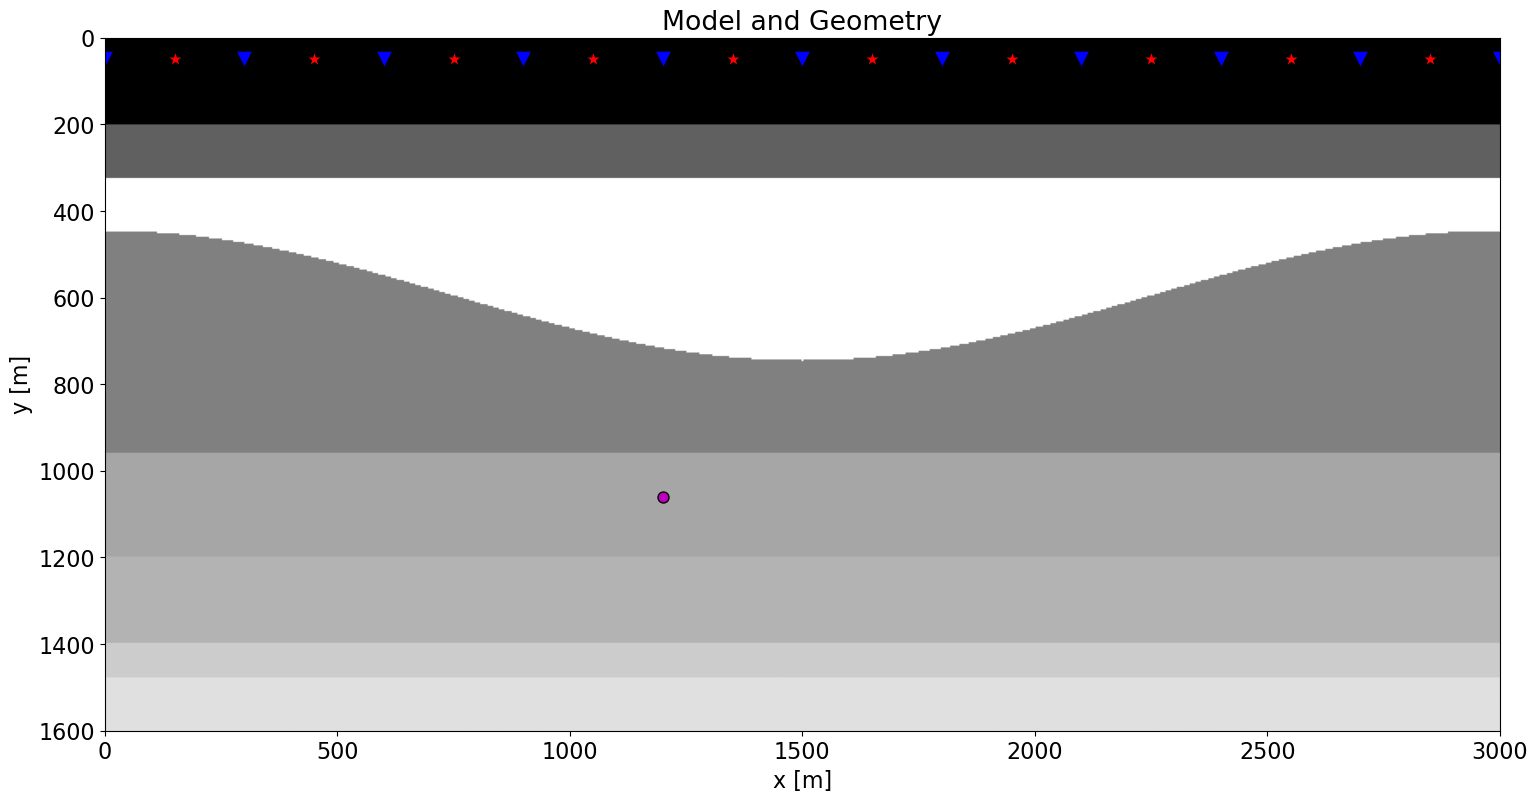

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)
t2 = np.concatenate([-np.flipud(t), t[1:]])

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

# wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)

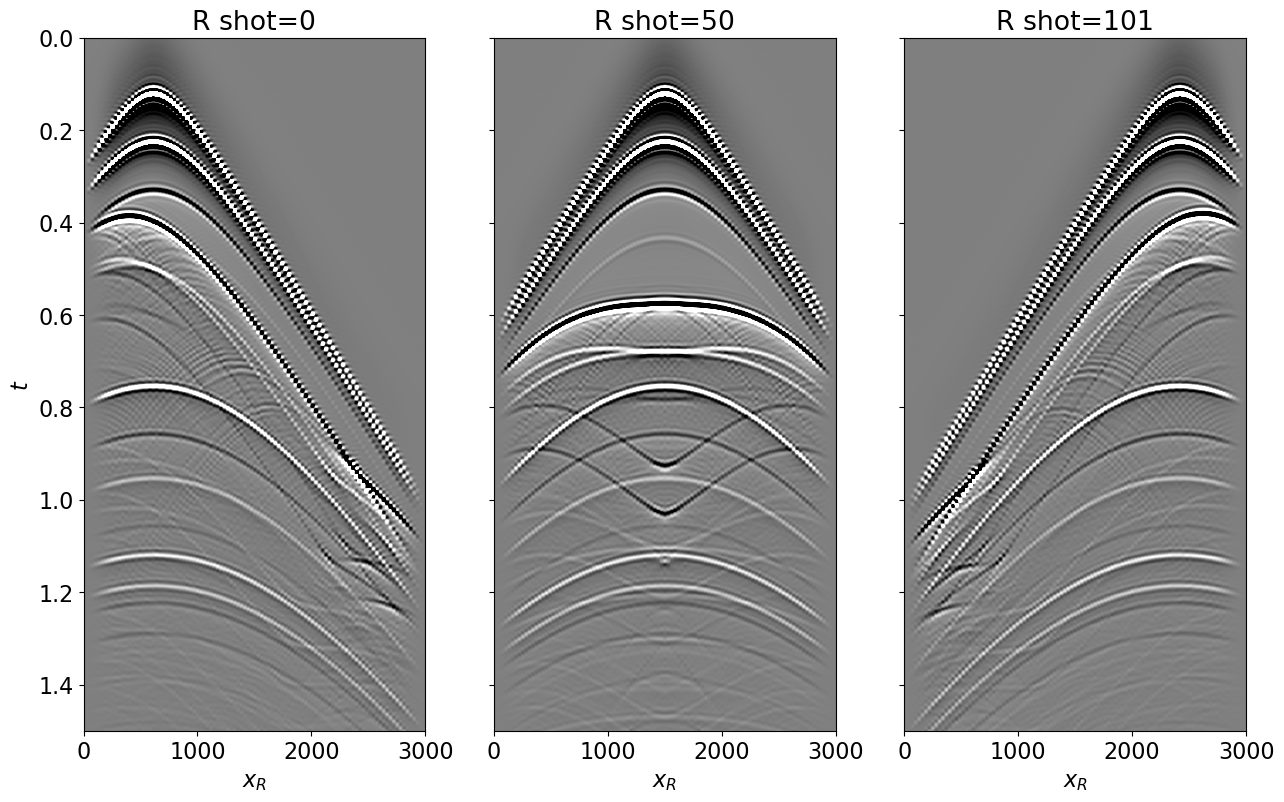

In [6]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0);

## Single source demultiple

In [7]:
Rwav = R[ns//2].T
Rwav = np.apply_along_axis(convolve, 0, Rwav, wav, mode='full')
Rwav = Rwav[wav_c:][:nt]

In [9]:
ntmax = nt

MarchenkoMME = MME(R, wav, wav_c, nt=nt, dt=dt, dr=dr, 
                   nfmax=nfmax, toff=toff, nsmooth=nsmooth)

U_minus = \
    MarchenkoMME.apply_onesrc(R[ns//2], ntmax=ntmax, n_iter=n_iter)

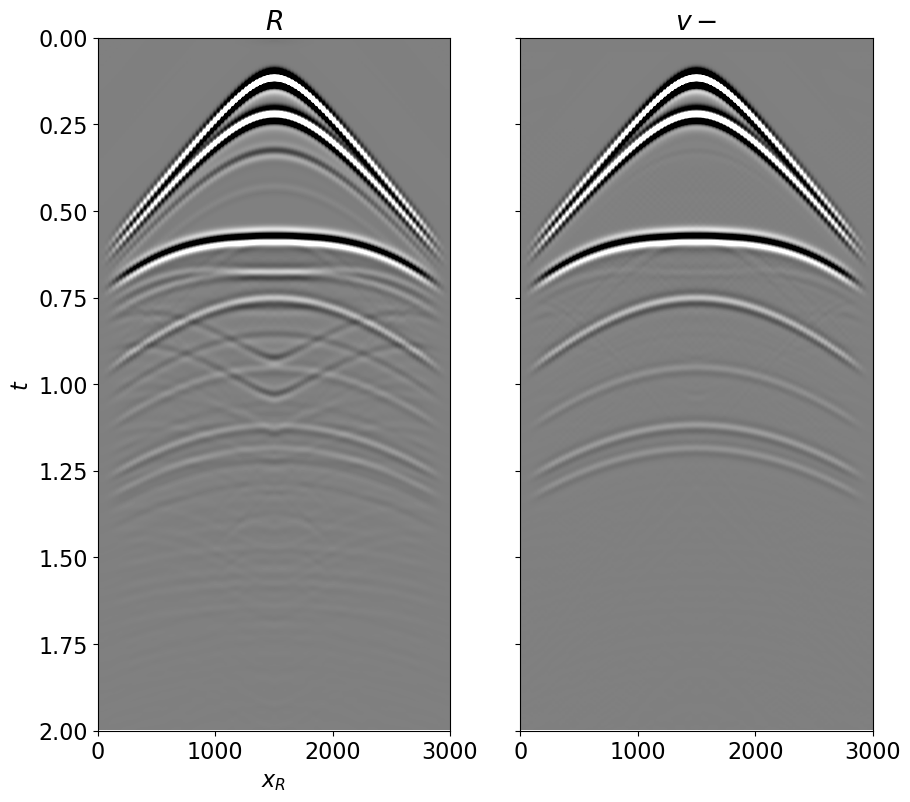

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(U_minus.T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

In [11]:
MarchenkoMME = MME(R, wav, wav_c, nt=nt, dt=dt, dr=dr, 
                   nfmax=nfmax, toff=toff, nsmooth=nsmooth)

U_minuscomp = \
    MarchenkoMME.apply_onesrc(R[ns//2], ntmax=ntmax, trcomp=True, n_iter=n_iter)

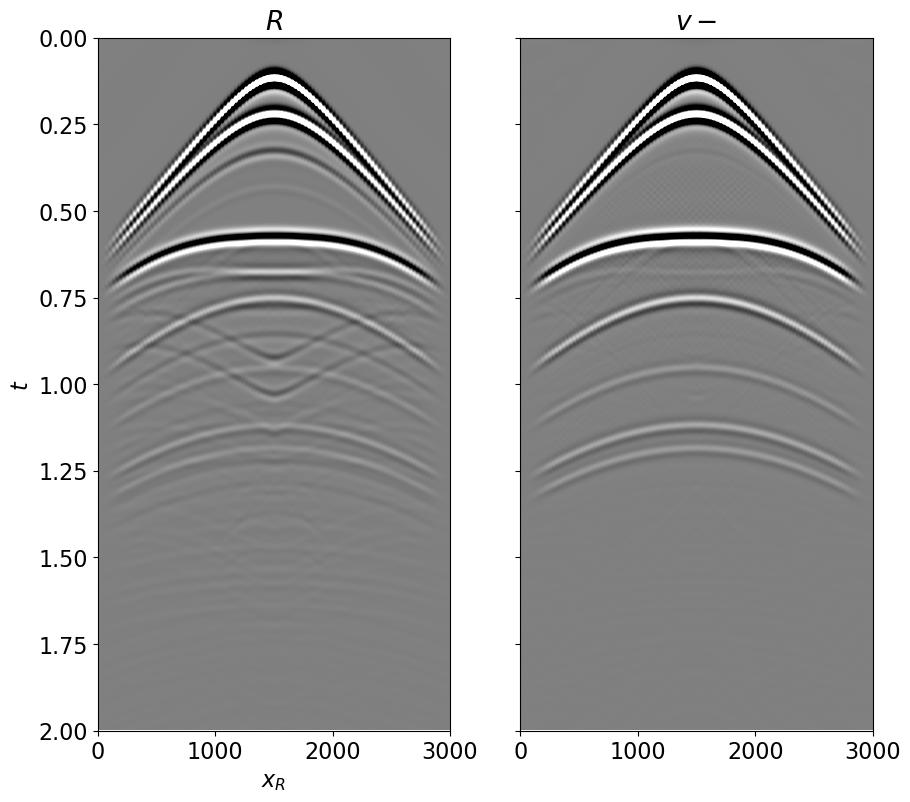

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(U_minuscomp.T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

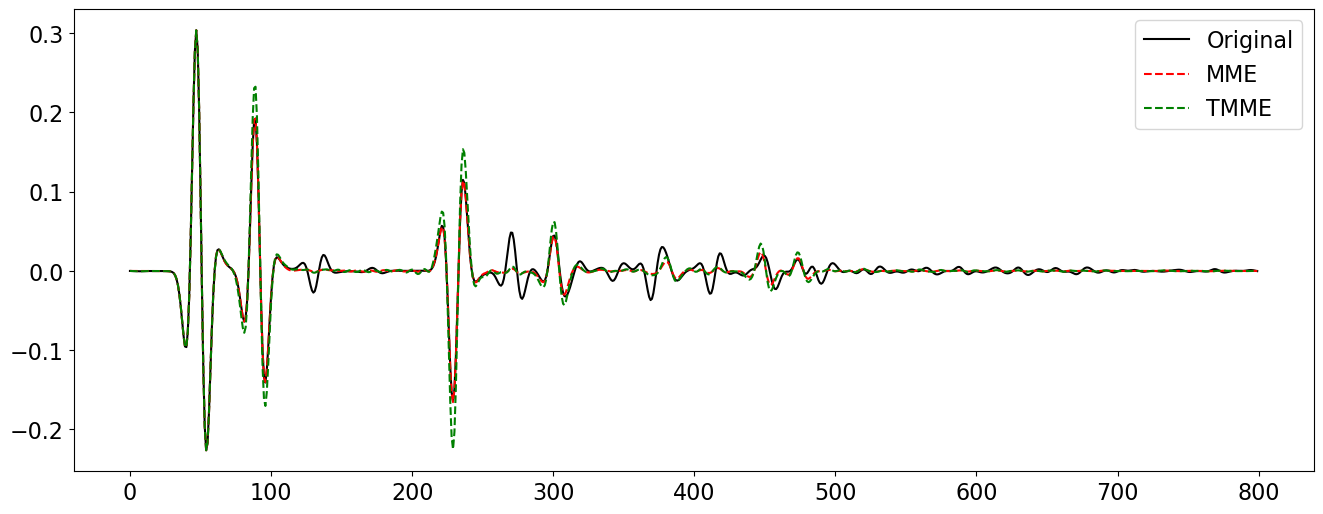

In [13]:
tgain = np.sqrt(t)
plt.figure(figsize=(16, 6))
plt.plot(tgain * Rwav[:, nr//2], 'k', label='Original')
plt.plot(tgain * U_minus[nr//2], '--r', label='MME');
plt.plot(tgain * U_minuscomp[nr//2], '--g', label='TMME')
plt.legend();

## Multiple sources demultiple

In [14]:
Rwav = R[::20]
Rwav = np.apply_along_axis(convolve, -1, Rwav, wav, mode='full')
Rwav = Rwav[..., wav_c:][..., :nt]

In [15]:
MarchenkoMME = MME(R, wav, wav_c, nt=nt, dt=dt, dr=dr, 
                   nfmax=nfmax, toff=toff, nsmooth=nsmooth)

U_minus = \
    MarchenkoMME.apply_multisrc(R[::20], ntmax=ntmax, n_iter=n_iter)

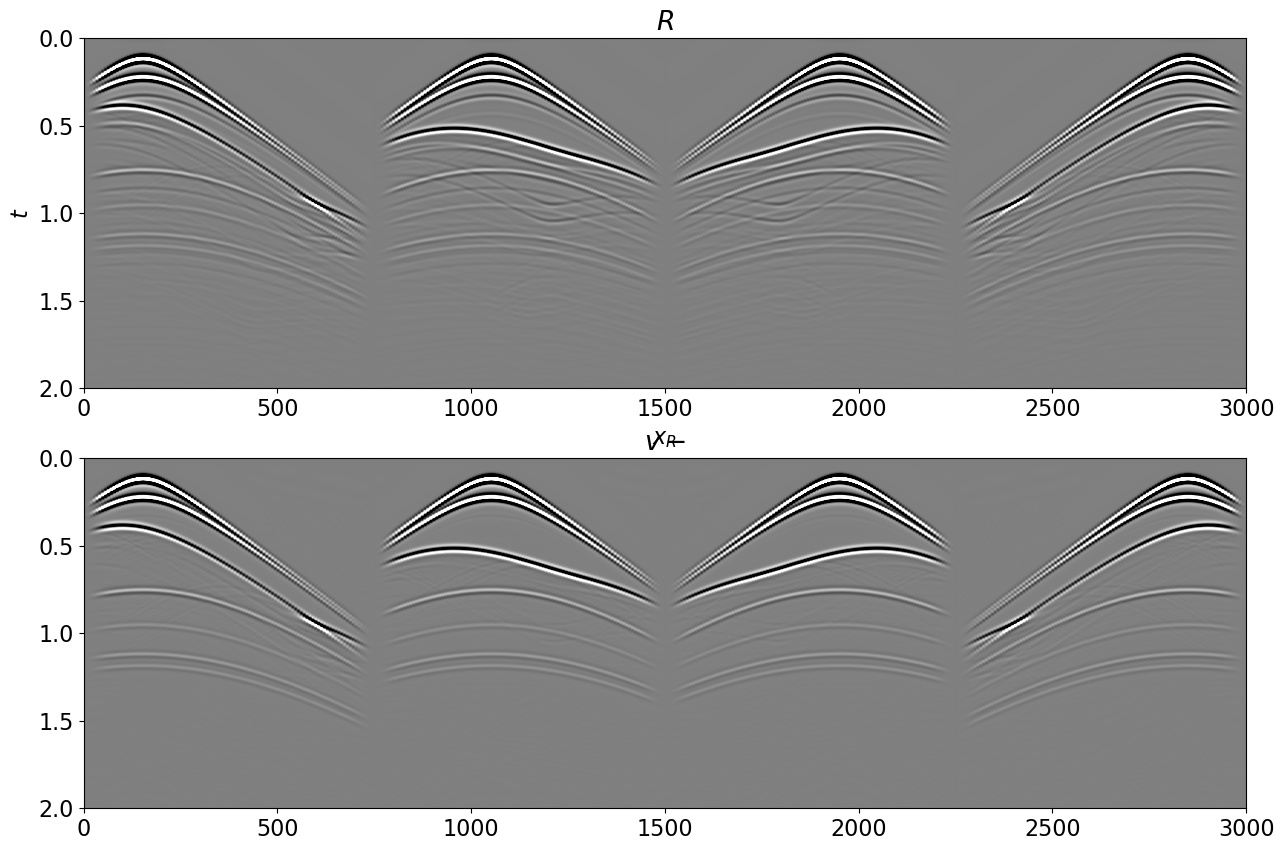

In [16]:
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(15, 10))
axs[0].imshow(Rwav[1:-1].reshape(4*nr, nt).T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(U_minus[1:-1].reshape(4*nr, nt).T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);